# **DCGAN** by myself
Using vanilla GAN with base code.

Change Discriminator from **MLP** to **CNN**

In [ ]:
import os
import torch
import torchvision
import cv2
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from matplotlib import pyplot as plt
from torch.nn.modules.pooling import MaxPool2d

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 100
hidden_size = 256
image_size = 4096
num_epochs = 200
batch_size = 100
root_dir = '/content/drive/MyDrive/MLDL/DCGAN'
sample_dir = root_dir + '/samples'

In [ ]:
# Change current path
os.chdir(root_dir)
print(os.getcwd())

/content/drive/MyDrive/MLDL/DCGAN


In [ ]:
transform = transforms.Compose([
                transforms.Resize(64),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])

In [ ]:
# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../data/',
                                   train=True,
                                   transform=transform,
                                   download=False)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

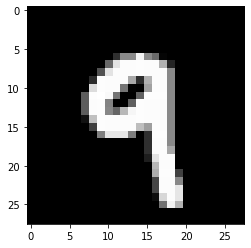

In [ ]:
# Check Dataset
for i in data_loader:
  plt.imshow(i[0][0][0,:,:],cmap='gray')
  break

In [ ]:
# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [ ]:
# Modified Discriminator
'''
 Discriminator를 단순히 MLP로 구성하는것이 아니라 CNN을 이용해서 feature를 뽑아낸 뒤 그것의 분포를 학습하고
 이를 마지막에 FCN으로 연결해주면 더 좋은 결과가 나오지 않을까 하는 생각에서 해보는 모델
'''

class Flatten(torch.nn.Module):
    def forward(self, x):
        return x.view(-1, 1).squeeze(1)

D = nn.Sequential(
    nn.Conv2d(1,64,kernel_size=4,stride=2,padding=1),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64 * 2),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64 * 4),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
    nn.BatchNorm2d(64 * 8),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
    nn.Sigmoid(),
    Flatten()
)

In [ ]:
# Device setting
D = D.to(device)
G = G.to(device)

In [ ]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [ ]:
from torchsummary import summary as summary_
summary_(D,(1,64,64),batch_size=100)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [100, 64, 32, 32]           1,088
         LeakyReLU-2          [100, 64, 32, 32]               0
            Conv2d-3         [100, 128, 16, 16]         131,072
       BatchNorm2d-4         [100, 128, 16, 16]             256
         LeakyReLU-5         [100, 128, 16, 16]               0
            Conv2d-6           [100, 256, 8, 8]         524,288
       BatchNorm2d-7           [100, 256, 8, 8]             512
         LeakyReLU-8           [100, 256, 8, 8]               0
            Conv2d-9           [100, 512, 4, 4]       2,097,152
      BatchNorm2d-10           [100, 512, 4, 4]           1,024
        LeakyReLU-11           [100, 512, 4, 4]               0
           Conv2d-12             [100, 1, 1, 1]           8,192
          Sigmoid-13             [100, 1, 1, 1]               0
          Flatten-14                   

In [ ]:
# Start training
total_step = len(data_loader)
num_epochs = 20
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.to(device)
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.full((batch_size,), 1,dtype=images.dtype).to(device)
        fake_labels = torch.full((batch_size,), 0, dtype=images.dtype).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        fake_images = torch.reshape(fake_images,(-1,1,64,64))
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        #print(fake_images)
        fake_images = torch.reshape(fake_images,(-1,1,64,64))
        outputs = D(fake_images)
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 64, 64)
        save_image(denorm(images), os.path.join(sample_dir, 'RealImages.png'))
    
    # Save sampled images
    save_image(denorm(fake_images), os.path.join(sample_dir, 'FakeImages-{}.png'.format(epoch+1)))
    

Epoch [0/20], Step [200/600], d_loss: 0.0000, g_loss: 10.8128, D(x): 1.00, D(G(z)): 0.00
Epoch [0/20], Step [400/600], d_loss: 0.0001, g_loss: 10.8499, D(x): 1.00, D(G(z)): 0.00
Epoch [0/20], Step [600/600], d_loss: 100.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [1/20], Step [200/600], d_loss: 100.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [1/20], Step [400/600], d_loss: 100.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [1/20], Step [600/600], d_loss: 100.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [2/20], Step [200/600], d_loss: 100.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [2/20], Step [400/600], d_loss: 100.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [2/20], Step [600/600], d_loss: 100.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [3/20], Step [200/600], d_loss: 100.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 1.00
Epoch [3/20], Step [400/600], d_loss: 100.0000, g_loss: 0.0000, D(x): 1.00, D(G(z)): 1.00


KeyboardInterrupt: ignored